## Kaytoo | Model Evaluation & Validating Inference
### Bird Call Classification for New Zealand 
This notebook builds the inference code for Kaytoo, and evaluates its performance.  The final functions and classes for actual deployment are to be moved into seperate `.py` scripts, so I can import them consistently into the inference `.py` script for deployment.

## Basic Setup
Adjust the dictionary below for the overall notebook use case.  Note that I am processing different sound clips in parallel.  If using the GPU this results in multiple batches being sent to the GPU by different cores, so the number of cores needs to be reduced.  With 4Gb VRAM, max num_cores is 2.  This is still faster than CPU only with 6 cores.  

**Benchmarking on 39 x 15-minute .wav files on a Dell G7**

- 2-cores GPU = 55 seconds
- 6-cores CPU = 103 seconds

In [1]:
dummy_cell = 0

In [2]:
notebook_use = {
                'project_root': '/home/olly/Desktop/Kaggle_BC25', 
                'experiment': '39_L0_131',
                'background_max_per_class' : 500,
                'background_threshold' : 0.6,
                'max_pl_samples': 20,
                'min_pl_threshold':0.6,
                'bird_name_csv': 'Data/Experiments/Exp_91/Exp_91_Deploy/exp_91_bird_map.csv',
                'folder_to_process': 'Data/Original_Data/birdclef-2025/train_soundscapes',
                'num_cores': 4,  #Can crank this up if using CPU only.
                'make_crops': True
                }

## Imports

In [3]:
#General Python
from pathlib import Path
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
import re

#External classes and functions
from bird_naming_utils import BirdNamer

#Math & Plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib.ticker import LogLocator

#Audio
import torchaudio
import soundfile as sf
import torch
from scipy.signal import resample

print('Imports Complete')

Imports Complete


## Configuration Classes

In [4]:
class DefaultConfig:
    def __init__(self, bird_namer, options=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if options:
            if options['num_cores']:
                self.CORES = options['num_cores']
            else:
                self.CORES = 1
        self.classes = bird_namer.bird_list

In [5]:
class AudioParameters:
    def __init__(self):
        self.SR = 32000
        self.FMIN = 20
        self.FMAX = 14000 

In [6]:
class FilePaths:
    AUDIO_TYPES = {'.ogg','.wav', '.flac', '.mp3'}
    def __init__(self, options=None):
        self.root_folder = Path(options['project_root'])
        self.data_folder = self.root_folder / 'Data'
        self.train_audios = self.data_folder / 'Original_Data/birdclef-2025/train_audio'
        self.experiment_results = self.data_folder / f"Experiments/Exp_{options['experiment']}/Results"
        self.prev_model_preds = self.experiment_results / f"exp_{options['experiment']}_soundscape_predictions.csv"
        self.val_csv = self.experiment_results / 'val_labels.csv'
        self.bird_list_path = self.root_folder / options['bird_name_csv']
        self.soundscapes_folder = self.root_folder /options['folder_to_process']
        self.soundscapes = [path for path in self.soundscapes_folder.rglob('*') if path.suffix in self.AUDIO_TYPES]
        self.new_backgrounds = self.data_folder / f"Cropped_Train_Soundscapes_{options['experiment']}"
        self.predictions_dir = self.data_folder / 'Soundscape_Predictions'        
        self.learning_rate_monitor = self.experiment_results / f"exp_{options['experiment']}_training_metrics.jpg"
        self.train_metric_monitor = self.experiment_results / 'learning_rate.jpg'
        self.val_preds = self.experiment_results / 'val_pred_df.pkl'
        self.val_targs = self.experiment_results / 'val_target_df.pkl'
        self.labels_parquet = self.data_folder / 'Train_Metadata' / f"background_labels_{options['experiment']}.parquet"
        self.pl_parquet = self.data_folder / 'Train_Metadata' / f"pseudolabels_{options['experiment']}.parquet"

        self.new_backgrounds.mkdir(parents=True, exist_ok=True)


## Helper Functions

In [7]:
class Colour:
    S = '\033[1m' + '\033[94m'
    E = '\033[0m'

## Initialise

In [8]:
audio = AudioParameters()
paths = FilePaths(options=notebook_use)
bird_map_df = pd.read_csv(paths.bird_list_path)
birdnames = BirdNamer(bird_map_df)

cfg = DefaultConfig(bird_namer=birdnames, 
                    options=notebook_use)


## Class Sizes and Distributions
First lets look at the classes and their sizes.

In [9]:
bird_map_df = bird_map_df.sort_values(by='TrainSamples').reset_index(drop=True)
bird_map_df.head(50)

,eBird,CommonName,ScientificName,Class,TrainSamples,ValSamples
0,rutpuf1,Russet-throated Puffbird,Hypnelus ruficollis,aves,18,3.0
1,42007,Mountain Lion,Puma concolor,mamalia,19,2.0
2,1139490,Ragoniella pulchella,Ragoniella pulchella,insecta,20,0.0
3,21116,Yellow-striped Poison Dart Frog,Dendrobates truncatus,amphibia,20,0.0
4,1194042,Copiphora colombiae,Copiphora colombiae,insecta,20,0.0
5,47067,Brown-throated Three-toed Sloth,Bradypus variegatus,mamalia,20,0.0
6,476537,Colombian Plump Frog,Elachistocleis pearsei,amphibia,20,0.0
7,476538,Panama Humming Frog,Elachistocleis panamensis,amphibia,20,0.0
8,523060,Eschatoceras bipunctatus,Eschatoceras bipunctatus,insecta,20,0.0
9,piwtyr1,Pied Water-Tyrant,Fluvicola pica,aves,20,0.0


In [10]:
bird_map_df[bird_map_df['eBird']=='52884'] 

,eBird,CommonName,ScientificName,Class,TrainSamples,ValSamples
112,52884,True Crickets,Gryllidae,insecta,106,11.0


In [11]:
bird_map_df[bird_map_df['eBird']=='compot1'] 

,eBird,CommonName,ScientificName,Class,TrainSamples,ValSamples
186,compot1,Common Potoo,Nyctibius griseus,aves,430,47.0


In [12]:
rarest = bird_map_df[bird_map_df['TrainSamples'] + bird_map_df['ValSamples'] <= 50]['eBird'].to_list()
print(rarest)

['rutpuf1', '42007', '1139490', '21116', '1194042', '47067', '476537', '476538', '523060', 'piwtyr1', 'plctan1', '24272', '24322', '24292', '41778', '528041', 'turvul', '548639', '65349', '65419', 'shghum1', 'sahpar1', '555142', '64862', '65336', '65344', '81930', '868458', '714022', '787625', '963335', '66016', '65962', '65547', '41970', '1192948', '21038', '66531', '66578', '66893', '67082', '126247', '42113', '1346504', '134933', '42087', '1462711', '46010', '1462737', '1564122', 'norscr1', '67252', 'bubcur1', 'ampkin1', 'bafibi1', '566513', '135045', '65373', 'grysee1', '715170', 'blctit1', '555086', 'whmtyr1', 'royfly1', 'cocher1', '48124', 'olipic1', 'woosto']


In [13]:
def plot_continuous(df, column_name, x_max=None, x_min=None, bins=None):
    plt.figure(figsize=(6, 4))
    ax = sns.histplot(df[column_name], bins=bins, kde=True)
    ax.set_yscale("log", base=2)  # Log scale with base 2
    ax.yaxis.set_major_locator(LogLocator(base=2.0, numticks=10))  # Control ticks
    plt.title(f'Distribution of {column_name} with {bins} Bins and KDE')
    plt.xlabel(column_name)
    ax.set(ylim=(1,40000))
    ax.set(xlim=(x_min, x_max) if x_min is not None and x_max is not None else None)
    plt.ylabel('Count')
    plt.show()

In [14]:
csv_files = list(paths.predictions_dir.glob("soundscape_predictions_39.csv"))
dfs = []
for path in csv_files:
    print(path)
    df = pd.read_csv(path)
    dfs.append(df)
    print(df.iloc[:5, :5])

/home/olly/Desktop/Kaggle_BC25/Data/Soundscape_Predictions/soundscape_predictions_39.csv
                   row_id   1139490   1192948   1194042    126247
0   H27_20230421_155000_0  0.020572  0.016837  0.014559  0.009488
1   H27_20230421_155000_3  0.020572  0.016837  0.014559  0.009488
2   H27_20230421_155000_6  0.020572  0.016837  0.014559  0.009488
3   H27_20230421_155000_9  0.020572  0.016837  0.014559  0.009488
4  H27_20230421_155000_12  0.020572  0.016837  0.014559  0.009488


In [15]:
# Preserve 'file_id' from the first DataFrame
result = pd.DataFrame()
result['row_id'] = dfs[0]['row_id']

# Get all columns except 'file_id'
value_columns = [col for col in dfs[0].columns if col != 'row_id']

# Stack and average the other columns
values_mean = sum(df[value_columns] for df in dfs) / len(dfs)

# Combine them
df = pd.concat([result, values_mean], axis=1)
df.head(30)

,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,H27_20230421_155000_0,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,...,0.063663,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.111470,0.051263
1,H27_20230421_155000_3,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,...,0.063663,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.111470,0.051263
2,H27_20230421_155000_6,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,...,0.063663,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.111470,0.051263
3,H27_20230421_155000_9,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,...,0.063663,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.111470,0.051263
4,H27_20230421_155000_12,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,...,0.063663,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.111470,0.051263
5,H27_20230421_155000_15,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,...,0.063663,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.111470,0.051263
6,H27_20230421_155000_18,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,...,0.063663,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.111470,0.051263
7,H27_20230421_155000_21,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,...,0.063663,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.111470,0.051263
8,H27_20230421_155000_24,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,...,0.063663,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.111470,0.051263
9,H27_20230421_155000_27,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,...,0.063663,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.111470,0.051263


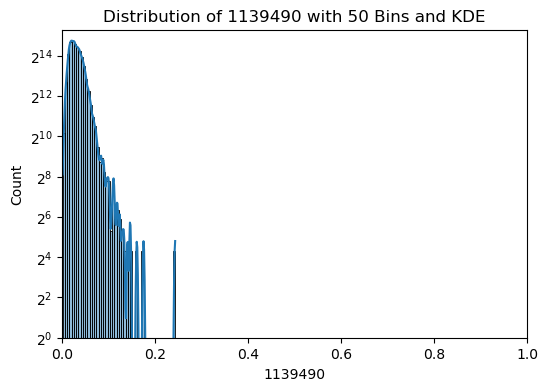

In [16]:
plot_continuous(df, '1139490', x_min = 0, x_max=1, bins=50)

In [17]:
#for bird in df.columns.to_list()[1:]:
#    print(bird)
#    plot_continuous(df.copy(), bird, x_min = 0, x_max=1, bins=50)

In [18]:
df_max = df.iloc[:, 1:].copy()
df_max['max_score'] = df_max.max(axis=1)
df_max.head(20)

,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,1564122,...,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar,max_score
0,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,0.014633,...,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.11147,0.051263,0.375983
1,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,0.014633,...,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.11147,0.051263,0.375983
2,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,0.014633,...,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.11147,0.051263,0.375983
3,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,0.014633,...,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.11147,0.051263,0.375983
4,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,0.014633,...,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.11147,0.051263,0.375983
5,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,0.014633,...,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.11147,0.051263,0.375983
6,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,0.014633,...,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.11147,0.051263,0.375983
7,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,0.014633,...,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.11147,0.051263,0.375983
8,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,0.014633,...,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.11147,0.051263,0.375983
9,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,0.014633,...,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.11147,0.051263,0.375983


In [19]:
df_max.shape

(194520, 207)

In [20]:
count = (df_max['max_score'] > 0.5).sum()
count

53560

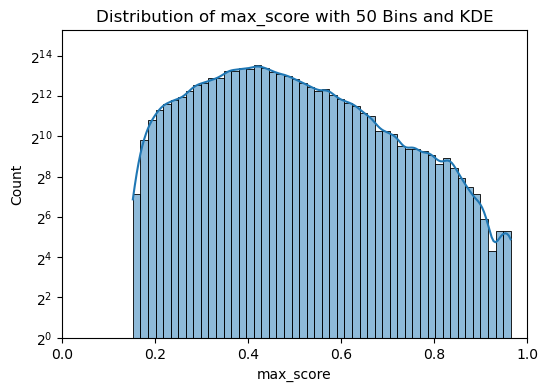

In [21]:
plot_continuous(df_max, 'max_score', x_min = 0, x_max=1, bins=50)

In [22]:
df_numeric = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')  # ensure numeric
df_max['second_from_max'] = df_numeric.apply(
    lambda row: row.nlargest(2).iloc[-1] if row.count() > 1 else row.max(),
    axis=1
)

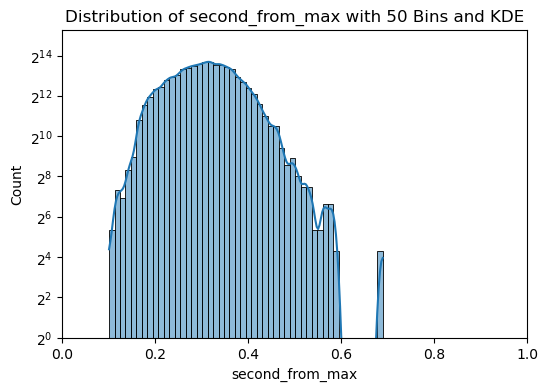

In [23]:
plot_continuous(df_max, 'second_from_max', x_min = 0, x_max=1, bins=50)

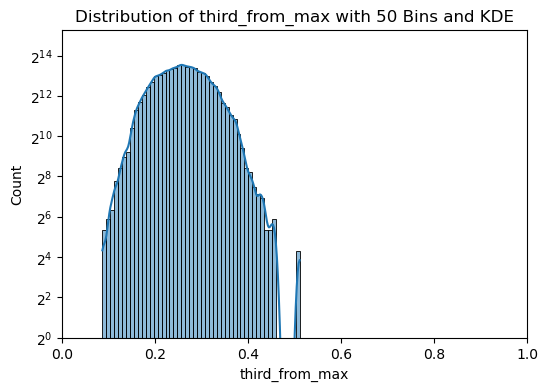

In [24]:
df_numeric = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')
df_max['third_from_max'] = df_numeric.apply(
    lambda row: row.nlargest(3).iloc[-1] if row.count() > 1 else row.max(),
    axis=1
)
plot_continuous(df_max, 'third_from_max', x_min = 0, x_max=1, bins=50)

In [25]:
df.head()

,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,H27_20230421_155000_0,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,...,0.063663,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.11147,0.051263
1,H27_20230421_155000_3,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,...,0.063663,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.11147,0.051263
2,H27_20230421_155000_6,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,...,0.063663,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.11147,0.051263
3,H27_20230421_155000_9,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,...,0.063663,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.11147,0.051263
4,H27_20230421_155000_12,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,...,0.063663,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.11147,0.051263


In [26]:
df.shape

(194520, 207)

In [27]:
threshold = 0.5
df_bin = df.copy()
# Identify numeric columns only
numeric_cols = df_bin.select_dtypes(include='number').columns

# Apply binary threshold
df_bin[numeric_cols] = (df_bin[numeric_cols] > threshold).astype(int)
df_bin = df_bin[~(df_bin.select_dtypes(include='number') == 0).all(axis=1)]
df_bin.head()

,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
260,H21_20230518_174000_0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
261,H21_20230518_174000_3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
262,H21_20230518_174000_6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
263,H21_20230518_174000_9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
264,H21_20230518_174000_12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


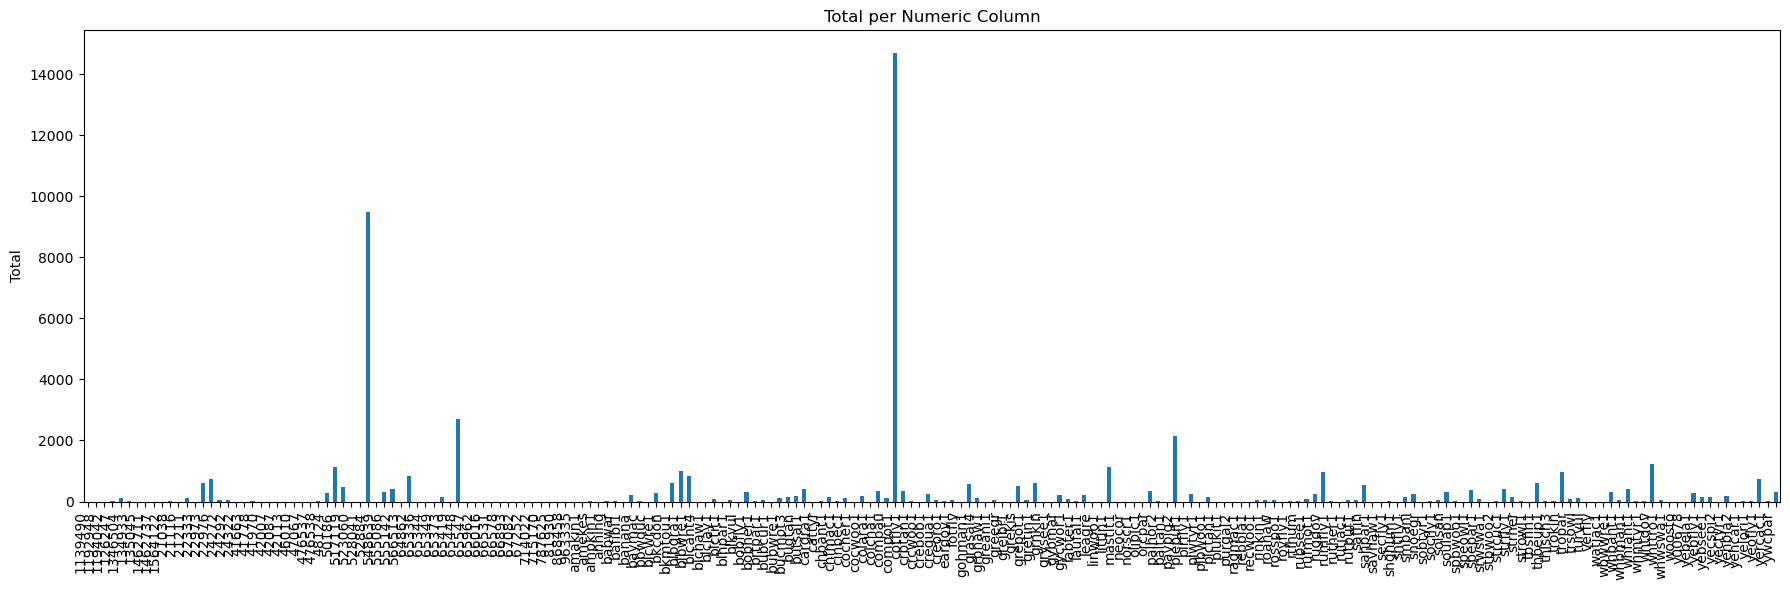

In [28]:
import matplotlib.pyplot as plt

# Sum each numeric column
column_totals = df_bin.select_dtypes(include='number').sum()

import matplotlib.pyplot as plt

# Set a wider figure size
plt.figure(figsize=(18, 6))  # Width=12 inches, Height=6 inches

# Sum and plot
column_totals = df_bin.select_dtypes(include='number').sum()
column_totals.plot(kind='bar')
plt.ylabel('Total')
plt.title('Total per Numeric Column')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

In [29]:
names = df.columns.tolist()[1:]
for total, name in zip(column_totals, names):
    if total > 1000:
        print(name, total)

50186 1120
52884 9480
65448 2700
compot1 14700
littin1 1120
pavpig2 2160
whtdov 1220


compot1, has over 6000 samples.  But only 300 in the training data   It's some kind of owl, so this is believable from night soundscapes
52884 is a common cricket, so not surprising at all.  And there are just 33 training samples!

Let's start again, but since we have so many owl and compot1 samples to burn, set a really high threshold for those two.


In [30]:
df.head()

,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,H27_20230421_155000_0,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,...,0.063663,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.11147,0.051263
1,H27_20230421_155000_3,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,...,0.063663,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.11147,0.051263
2,H27_20230421_155000_6,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,...,0.063663,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.11147,0.051263
3,H27_20230421_155000_9,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,...,0.063663,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.11147,0.051263
4,H27_20230421_155000_12,0.020572,0.016837,0.014559,0.009488,0.010178,0.041238,0.025885,0.014499,0.013865,...,0.063663,0.034133,0.088696,0.035924,0.056351,0.065219,0.071319,0.095855,0.11147,0.051263


In [31]:
#Not in use, just keeping as a record from the first version that produced LB scores about 0.84
default_thresh = notebook_use['background_threshold']
custom_thresholds = {
    'compot1': .55,  #Was 0.65 for exps 83 on,  put back to 0.7 for exp 92
    '52884': .75,
    'pavpig2' :0.62,
    '65448':0.65,
}

In [32]:
def get_thresholds(df, default_threshold, max_per_class):
    class_scores = df.iloc[:, 1:]
    # Compute thresholds: each is the value above which there are at most max_per_class values
    thresholds = class_scores.apply(lambda col: col.nlargest(max_per_class).min(), axis=0)
    all_thresholds = thresholds.to_dict()
    all_thresholds = {key:round(max(val,default_threshold),3) for key, val in all_thresholds.items()}

    return all_thresholds

background_thresholds = get_thresholds(df,
                                       notebook_use['background_threshold'],
                                       notebook_use['background_max_per_class'])

background_thresholds

{'1139490': 0.6,
 '1192948': 0.6,
 '1194042': 0.6,
 '126247': 0.6,
 '1346504': 0.6,
 '134933': 0.6,
 '135045': 0.6,
 '1462711': 0.6,
 '1462737': 0.6,
 '1564122': 0.6,
 '21038': 0.6,
 '21116': 0.6,
 '21211': 0.6,
 '22333': 0.6,
 '22973': 0.6,
 '22976': 0.6,
 '24272': 0.6,
 '24292': 0.6,
 '24322': 0.6,
 '41663': 0.6,
 '41778': 0.6,
 '41970': 0.6,
 '42007': 0.6,
 '42087': 0.6,
 '42113': 0.6,
 '46010': 0.6,
 '47067': 0.6,
 '476537': 0.6,
 '476538': 0.6,
 '48124': 0.6,
 '50186': 0.6,
 '517119': 0.6,
 '523060': 0.6,
 '528041': 0.6,
 '52884': 0.677,
 '548639': 0.6,
 '555086': 0.6,
 '555142': 0.6,
 '566513': 0.6,
 '64862': 0.6,
 '65336': 0.6,
 '65344': 0.6,
 '65349': 0.6,
 '65373': 0.6,
 '65419': 0.6,
 '65448': 0.821,
 '65547': 0.6,
 '65962': 0.6,
 '66016': 0.6,
 '66531': 0.6,
 '66578': 0.6,
 '66893': 0.6,
 '67082': 0.6,
 '67252': 0.6,
 '714022': 0.6,
 '715170': 0.6,
 '787625': 0.6,
 '81930': 0.6,
 '868458': 0.6,
 '963335': 0.6,
 'amakin1': 0.6,
 'amekes': 0.6,
 'ampkin1': 0.6,
 'anhing': 0.6,

In [33]:
def filter_samples(df_0, thresholds):
    # Apply thresholding to all columns except 'row_id'
    thresholded = df_0.drop(columns='row_id').apply(
        lambda col: (col > thresholds.get(col.name, 0)).astype(int)
    )

    thresholded = thresholded[~(thresholded == 0).all(axis=1)]
    df = df_0.loc[thresholded.index, ['row_id']].join(thresholded)

    return df

df_binary = filter_samples(df.copy(), background_thresholds)
df_binary.head()

,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
300,H8920_20230429_082000_0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
301,H8920_20230429_082000_3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
302,H8920_20230429_082000_6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
303,H8920_20230429_082000_9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
304,H8920_20230429_082000_12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The goal here is to have a lot of samples, and not be so fussy about their accuracy, so no one class is too dominant, and we also minimise risk of over-training.

In [34]:
df_binary.shape

(12420, 207)

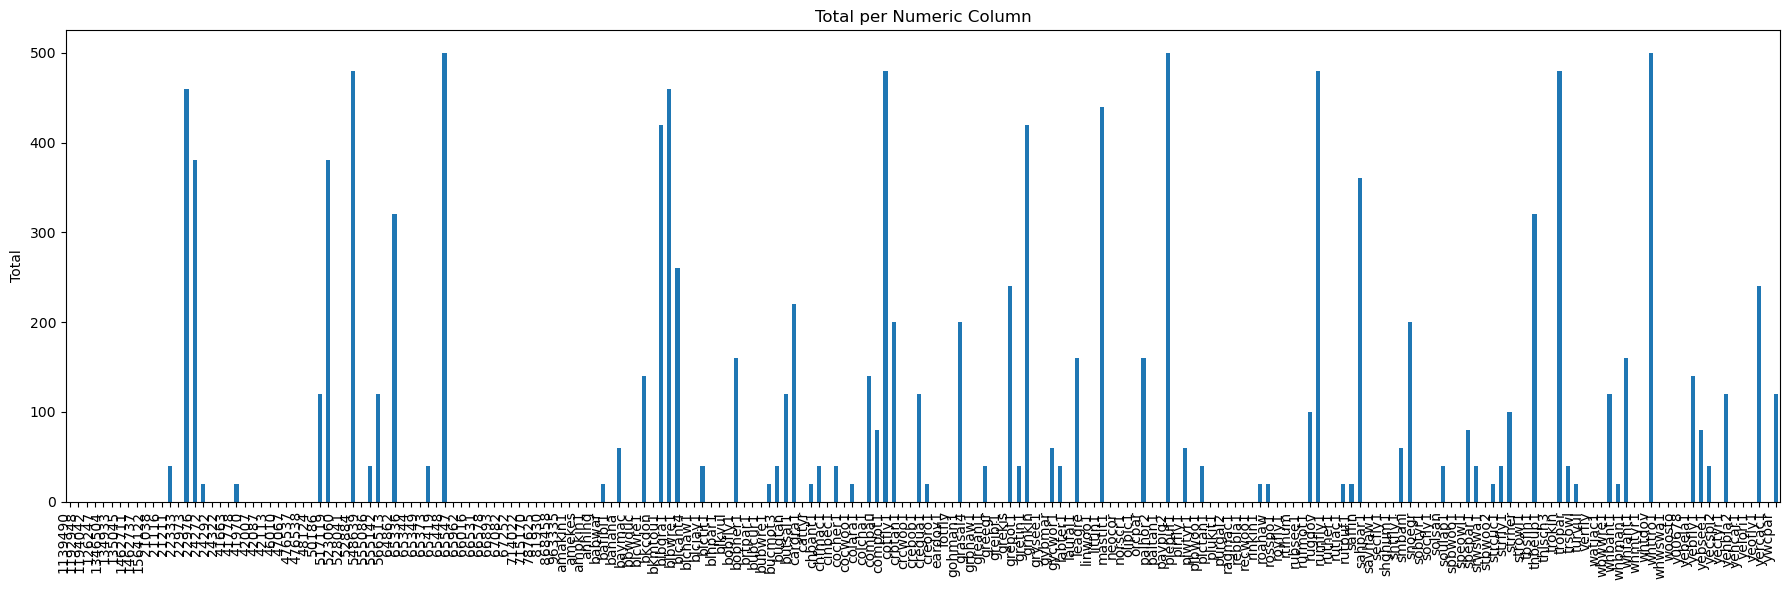

In [35]:
# Sum each numeric column
def plot_class_sizes(df):
    column_totals = df.select_dtypes(include='number').sum()
    plt.figure(figsize=(18, 6))  # Width=12 inches, Height=6 inches
    column_totals = df.select_dtypes(include='number').sum()
    column_totals.plot(kind='bar')
    plt.ylabel('Total')
    plt.title('Total per Numeric Column')
    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()
    plt.show()

plot_class_sizes(df_binary)

In [36]:
def format_label_df(df):
    df_bin = df.copy()
    df_bin['start'] = (
        df_bin['row_id']
        .str.extract(r'_(\d+)$')[0]   # Extract number at the end
        .astype(int)        # Apply your scaling because the orignal notebook labelled wrong
    ).round().astype(int)  
    df_bin['end'] = df_bin['start'] + 6
    
    df_bin['filename'] = df_bin.apply(
    lambda row: re.sub(r'_[^_]+$', f"_{row['end']}.ogg", row['row_id']),
    axis=1
    )

    name_cols = df_bin.columns.to_list()[1:-3]
    df_bin = df_bin[['filename', 'row_id', 'start', 'end'] + name_cols]
    df_bin['row_id'] = df_bin['row_id'].str.replace(r'_[^_]+$', '.ogg', regex=True)
    
    return df_bin

df_bin = format_label_df(df_binary)

In [37]:
df_bin.head()

,filename,row_id,start,end,1139490,1192948,1194042,126247,1346504,134933,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
300,H8920_20230429_082000_6.ogg,H8920_20230429_082000.ogg,0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
301,H8920_20230429_082000_9.ogg,H8920_20230429_082000.ogg,3,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
302,H8920_20230429_082000_12.ogg,H8920_20230429_082000.ogg,6,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
303,H8920_20230429_082000_15.ogg,H8920_20230429_082000.ogg,9,15,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
304,H8920_20230429_082000_18.ogg,H8920_20230429_082000.ogg,12,18,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's grab a handy list of all the filenames being kept for later work with the rare samples

In [38]:
selected_files = df_binary['row_id'].tolist()
selected_files[:5]

['H8920_20230429_082000_0',
 'H8920_20230429_082000_3',
 'H8920_20230429_082000_6',
 'H8920_20230429_082000_9',
 'H8920_20230429_082000_12']

Just for curiosity, let's see how many classes are actually represented

In [39]:
df_curiosity = df_bin.loc[:, (df_bin != 0).any(axis=0)]
df_curiosity.columns.shape

(81,)

## Make pseudolabels with highest certainty samples
Now let's repeat this but much more selectively to provide some pseudolabelled samples to mix into the training samples.

In [40]:
df_all_samples = df[df['row_id'].isin(selected_files)]
df_all_samples.head()

,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
300,H8920_20230429_082000_0,0.017808,0.025381,0.014774,0.053054,0.006089,0.044913,0.021688,0.014609,0.026404,...,0.083049,0.037591,0.049089,0.098414,0.035537,0.051562,0.031324,0.108855,0.073785,0.037894
301,H8920_20230429_082000_3,0.017808,0.025381,0.014774,0.053054,0.006089,0.044913,0.021688,0.014609,0.026404,...,0.083049,0.037591,0.049089,0.098414,0.035537,0.051562,0.031324,0.108855,0.073785,0.037894
302,H8920_20230429_082000_6,0.017808,0.025381,0.014774,0.053054,0.006089,0.044913,0.021688,0.014609,0.026404,...,0.083049,0.037591,0.049089,0.098414,0.035537,0.051562,0.031324,0.108855,0.073785,0.037894
303,H8920_20230429_082000_9,0.017808,0.025381,0.014774,0.053054,0.006089,0.044913,0.021688,0.014609,0.026404,...,0.083049,0.037591,0.049089,0.098414,0.035537,0.051562,0.031324,0.108855,0.073785,0.037894
304,H8920_20230429_082000_12,0.017808,0.025381,0.014774,0.053054,0.006089,0.044913,0.021688,0.014609,0.026404,...,0.083049,0.037591,0.049089,0.098414,0.035537,0.051562,0.031324,0.108855,0.073785,0.037894


In [41]:
_df = df_all_samples.copy()
_df['row_id'] = _df['row_id'].str.replace(r'_\d+$', '.ogg', regex=True)
df_with_max = _df.set_index('row_id')
# Find the column name with the maximum value per row for the 'prinary label' later
primary_labels = df_with_max.idxmax(axis=1).to_dict()

In [42]:
pl_thresholds  = get_thresholds(df.copy(),
                                notebook_use['min_pl_threshold'],
                                notebook_use['max_pl_samples'])
pl_thresholds

{'1139490': 0.6,
 '1192948': 0.6,
 '1194042': 0.6,
 '126247': 0.6,
 '1346504': 0.6,
 '134933': 0.6,
 '135045': 0.6,
 '1462711': 0.6,
 '1462737': 0.6,
 '1564122': 0.6,
 '21038': 0.6,
 '21116': 0.6,
 '21211': 0.676,
 '22333': 0.6,
 '22973': 0.839,
 '22976': 0.789,
 '24272': 0.66,
 '24292': 0.6,
 '24322': 0.6,
 '41663': 0.6,
 '41778': 0.619,
 '41970': 0.6,
 '42007': 0.6,
 '42087': 0.6,
 '42113': 0.6,
 '46010': 0.6,
 '47067': 0.6,
 '476537': 0.6,
 '476538': 0.6,
 '48124': 0.6,
 '50186': 0.699,
 '517119': 0.803,
 '523060': 0.6,
 '528041': 0.6,
 '52884': 0.802,
 '548639': 0.6,
 '555086': 0.677,
 '555142': 0.652,
 '566513': 0.6,
 '64862': 0.727,
 '65336': 0.6,
 '65344': 0.6,
 '65349': 0.6,
 '65373': 0.694,
 '65419': 0.6,
 '65448': 0.909,
 '65547': 0.6,
 '65962': 0.6,
 '66016': 0.6,
 '66531': 0.6,
 '66578': 0.6,
 '66893': 0.6,
 '67082': 0.6,
 '67252': 0.6,
 '714022': 0.6,
 '715170': 0.6,
 '787625': 0.6,
 '81930': 0.6,
 '868458': 0.6,
 '963335': 0.6,
 'amakin1': 0.6,
 'amekes': 0.6,
 'ampkin1':

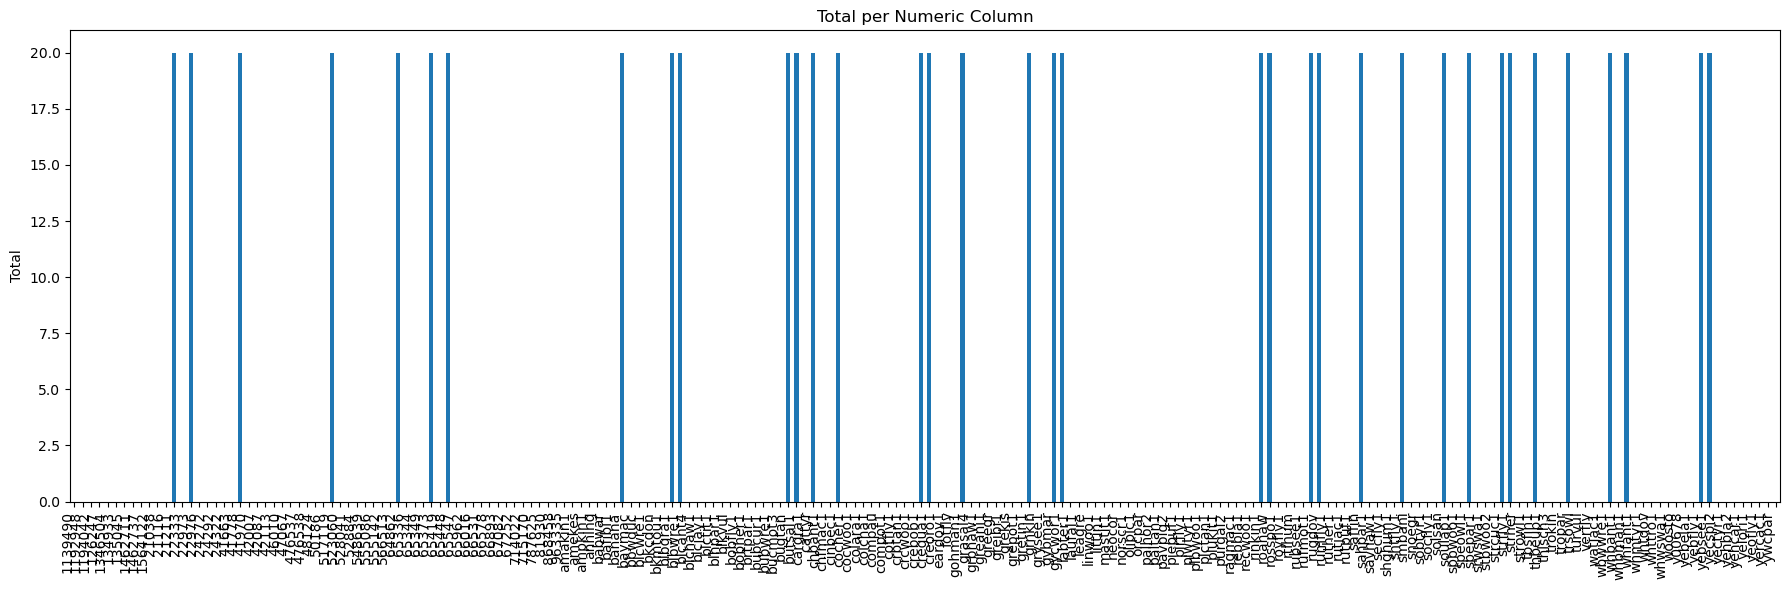

In [43]:
df_pl_binary = filter_samples(df_all_samples.copy(), pl_thresholds)
plot_class_sizes(df_pl_binary)

In [44]:
df_pl_bin = format_label_df(df_pl_binary)
df_pl_bin.head()

,filename,row_id,start,end,1139490,1192948,1194042,126247,1346504,134933,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
4560,H98_20230510_102000_6.ogg,H98_20230510_102000.ogg,0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4561,H98_20230510_102000_9.ogg,H98_20230510_102000.ogg,3,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4562,H98_20230510_102000_12.ogg,H98_20230510_102000.ogg,6,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4563,H98_20230510_102000_15.ogg,H98_20230510_102000.ogg,9,15,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4564,H98_20230510_102000_18.ogg,H98_20230510_102000.ogg,12,18,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Further formatting so it exactly matches the train_df   in the training code.

In [45]:
df_pl_bin['centres'] = None
df_pl_bin['filepath'] = str(paths.new_backgrounds) + '/' + df_pl_bin['filename'] 
df_pl_bin.head()

,filename,row_id,start,end,1139490,1192948,1194042,126247,1346504,134933,...,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar,centres,filepath
4560,H98_20230510_102000_6.ogg,H98_20230510_102000.ogg,0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,None,/home/olly/Desktop/Kaggle_BC25/Data/Cropped_Tr...
4561,H98_20230510_102000_9.ogg,H98_20230510_102000.ogg,3,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,None,/home/olly/Desktop/Kaggle_BC25/Data/Cropped_Tr...
4562,H98_20230510_102000_12.ogg,H98_20230510_102000.ogg,6,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,None,/home/olly/Desktop/Kaggle_BC25/Data/Cropped_Tr...
4563,H98_20230510_102000_15.ogg,H98_20230510_102000.ogg,9,15,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,None,/home/olly/Desktop/Kaggle_BC25/Data/Cropped_Tr...
4564,H98_20230510_102000_18.ogg,H98_20230510_102000.ogg,12,18,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,None,/home/olly/Desktop/Kaggle_BC25/Data/Cropped_Tr...


Let's look more specifically at the prevalence of pseudolablled samples that are among the rarest of the original samples.

In [46]:
rarest[:10]

['rutpuf1',
 '42007',
 '1139490',
 '21116',
 '1194042',
 '47067',
 '476537',
 '476538',
 '523060',
 'piwtyr1']

In [47]:
df_rare = df_pl_bin[['filename'] + rarest].copy()
df_rare.head()

,filename,rutpuf1,42007,1139490,21116,1194042,47067,476537,476538,523060,...,grysee1,715170,blctit1,555086,whmtyr1,royfly1,cocher1,48124,olipic1,woosto
4560,H98_20230510_102000_6.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4561,H98_20230510_102000_9.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4562,H98_20230510_102000_12.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4563,H98_20230510_102000_15.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4564,H98_20230510_102000_18.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
df_rare_only = df_rare.loc[:, (df_rare != 0).any(axis=0)]
df_rare_only.head()

,filename,41778,64862,65373
4560,H98_20230510_102000_6.ogg,0,0,0
4561,H98_20230510_102000_9.ogg,0,0,0
4562,H98_20230510_102000_12.ogg,0,0,0
4563,H98_20230510_102000_15.ogg,0,0,0
4564,H98_20230510_102000_18.ogg,0,0,0


In [49]:
rare_finds = df_rare_only.columns.to_list()[1:]
rare_finds

['41778', '64862', '65373']

In [50]:
df_rare.shape

(720, 69)

In [51]:
column_totals_df = df_rare.sum(axis=0).to_frame(name="total")
column_totals_df

,total
filename,H98_20230510_102000_6.oggH98_20230510_102000_9...
rutpuf1,0
42007,0
1139490,0
21116,0
...,...
royfly1,0
cocher1,0
48124,0
olipic1,0


In [52]:
column_totals = df_rare.sum(axis=0).reset_index()
column_totals.columns = ['Category', 'Count']

fig = px.bar(column_totals, x='Category', y='Count', title='Column Totals')
fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [53]:
label_counts_df = pd.read_csv(paths.data_folder / 'Train_Metadata/primary_label_counts.csv')
label_counts_df = label_counts_df[label_counts_df['primary_label'].isin(rare_finds)]
label_counts_df.head(40)

,Unnamed: 0,primary_label,total_count
142,142,65373,32
201,201,64862,2
203,203,41778,2


It will be very interesting to see if these samples improve in performance

## Make The Audio Crops

In [54]:
def load_file(path):
    try:
        waveform, sr = torchaudio.load(path)
        y = waveform.numpy()
        if y.shape[0] == 2:
            y = y.mean(axis=0)
        else:
            y = y.squeeze()

        loaded_length = len(y)//sr
        if loaded_length <= 1:
            print(f'Warning, the loaded clip length is only {loaded_length} seconds for the file {path}')
        return y, sr
    except Exception as e:
        print(f"Error processing file {path}: {e}")
        return None, None


def process_group(row_id,
                  group, 
                 in_folder = paths.soundscapes_folder,
                 out_folder = paths.new_backgrounds,
                 default_sr = 32000):
    filename = row_id
    in_path = str(in_folder / filename)

    #print(in_path)
    y, sr = load_file(in_path)

    if y is not None:
        #append 3 secs from the start to the end, as was done during evaluation
        start_segment = y[:sr*3]
        y = np.concatenate([y, start_segment]) 
        

        for _, row in group.iterrows():
            start=row.start * sr
            end = row.end * sr
            part = y[start:end]
            if len(part) >=1:
                out_path = str(out_folder / row.filename)
                if sr != default_sr:
                    num_samples = int(len(part) * default_sr / sr)
                    part = resample(part, num_samples)
                sf.write(out_path, part, default_sr)
    return


In [55]:
if notebook_use['make_crops']:
    grouped = df_bin.groupby('row_id')
    results = Parallel(n_jobs=notebook_use['num_cores'])(
        delayed(process_group)(row_id, group)
        for row_id, group in tqdm(grouped)
    )

  0%|          | 0/621 [00:00<?, ?it/s]

## Save the labelling dataframes to Parquet

In [56]:
df_bin = df_bin[['filename'] + names].reset_index(drop=True)
df_bin.to_parquet(paths.labels_parquet)
df_check = pd.read_parquet(paths.labels_parquet)
df_check.head()

,filename,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,H8920_20230429_082000_6.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,H8920_20230429_082000_9.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,H8920_20230429_082000_12.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,H8920_20230429_082000_15.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,H8920_20230429_082000_18.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
df_pl_bin['primary_label'] = df_pl_bin['row_id'].map(primary_labels)

In [58]:
df_pl = df_pl_bin[['primary_label', 'filepath', 'centres'] + names].reset_index(drop=True)
df_pl.head()

,primary_label,filepath,centres,1139490,1192948,1194042,126247,1346504,134933,135045,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,solsan,/home/olly/Desktop/Kaggle_BC25/Data/Cropped_Tr...,None,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,solsan,/home/olly/Desktop/Kaggle_BC25/Data/Cropped_Tr...,None,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,solsan,/home/olly/Desktop/Kaggle_BC25/Data/Cropped_Tr...,None,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,solsan,/home/olly/Desktop/Kaggle_BC25/Data/Cropped_Tr...,None,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,solsan,/home/olly/Desktop/Kaggle_BC25/Data/Cropped_Tr...,None,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
df_pl.to_parquet(paths.pl_parquet)
df_check = pd.read_parquet(paths.pl_parquet)
df_check.head()

,primary_label,filepath,centres,1139490,1192948,1194042,126247,1346504,134933,135045,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,solsan,/home/olly/Desktop/Kaggle_BC25/Data/Cropped_Tr...,None,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,solsan,/home/olly/Desktop/Kaggle_BC25/Data/Cropped_Tr...,None,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,solsan,/home/olly/Desktop/Kaggle_BC25/Data/Cropped_Tr...,None,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,solsan,/home/olly/Desktop/Kaggle_BC25/Data/Cropped_Tr...,None,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,solsan,/home/olly/Desktop/Kaggle_BC25/Data/Cropped_Tr...,None,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
